This notebook imports and aligns pacbio amplicons. 

In [1]:
import os
import warnings

from IPython.display import HTML, display

import numpy

import pandas as pd

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

import plotnine as p9

In [2]:
warnings.simplefilter('ignore')

In [3]:
p9.theme_set(dms_variants.plotnine_themes.theme_graygrid())

Import snakemake variables

In [4]:
# amplicons = snakemake.input.amplicons
# features = snakemake.input.features
# plot_amplicons = snakemake.output.plot_amplicons
# ccs_report = snakemake.input.ccs_report
# ccs_fastq = snakemake.input.ccs_fastq
# runs = snakemake.params.runs
# alignment_stats = snakemake.output.alignment_stats

amplicons = "../data/flu_sequences/pacbio_amplicons/fluCA.gb"
features = "../data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml"
plot_amplicons = "../results/pacbio/hashing_highMOI_amplicons.svg"
ccs_report = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt"
ccs_fastq = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs.fastq.gz"
runs = ["hashing_highMOI_2020-10-20_all_segments_run1_ccs"]
outdir= "../results/pacbio/CA09_align_and_parse"
os.makedirs(outdir, exist_ok=True)
alignment_stats = outdir



Here we import targetfiles for amplicons that where made using primers that either aligned to ends of flu sequences ('termini') or primers aligning approximately to the middle of a segment ('mid').

In [5]:
targetfile = amplicons

nlines_to_show = 100
with open(targetfile) as f:
    print(''.join(next(f) for _ in range(nlines_to_show)))

LOCUS       HAmid                2123 bp ds-DNA     linear   SYN 05-NOV-2020
DEFINITION  HAmid
ACCESSION   HAmid 
VERSION     .
KEYWORDS    .
SOURCE      HAmid 
  ORGANISM  PCR product
FEATURES             Location/Qualifiers
     sequenced_mRNA_1 1..870
     variant_tag_2    750
     viral_barcode    892..907
     polyA            1079..1107
     UMI              1108..1119
     cellbarcode      1120..1135
     Read1            1136..1155
     termini5         1156..1180
     sequenced_mRNA_2 1261..2123
     variant_tag_1    1404
ORIGIN
        1 gctggatctg gtattatcat ttcagataca ccagtccacg attgcaatac aacttgtcaa
       61 acacccaagg gtgctataaa caccagcctc ccatttcaga atatacatcc gatcacaatt
      121 ggaaaatgtc caaaatatgt aaaaagcaca aaattgagac tggccacagg attgaggaat
      181 atcccgtcta ttcaatctag aggcctattt ggggccattg ccggtttcat tgaagggggg
      241 tggacaggga tggtagatgg atggtacggt tatcaccatc aaaatgagca ggggtcagga
      301 tatgcagccg acctgaagag cacacagaat gccattgacg agattactaa caaagtaaat


Feature file defines features in amplicon genbank file. 

In [6]:
feature_parse_specs_file = features
with open(feature_parse_specs_file) as f:
    print(f.read())

# default for genes with two variant tags
default_2tags: &default_2tags
  query_clip5: 5
  query_clip3: 5
  termini5:
    filter:
      mutation_nt_count: 2
      mutation_op_count: null 
  sequenced_mRNA_1:
    filter:
      clip5: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  sequenced_mRNA_2:
    filter:
      clip3: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]  
  polyA:
    filter:
      mutation_nt_count: null
      mutation_op_count: 4
  UMI:
    return: [sequence, accuracy]
  cellbarcode:
    return: [sequence, accuracy]
  variant_tag_1:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
  variant_tag_2:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
# default for genes with one variant tags
default_1tag: &default_1tag
  query_clip5: 5
  query_clip3: 5
  termini5:
    filter:
      mutation_nt_count:

In [7]:
targets = alignparse.targets.Targets(
                seqsfile=targetfile,
                feature_parse_specs=feature_parse_specs_file,
                ignore_feature_parse_specs_keys=['default_2tags', 'default_1tag'],
                allow_extra_features=True,
                allow_clipped_muts_seqs=True)

Now let's plot all segment amplicons.

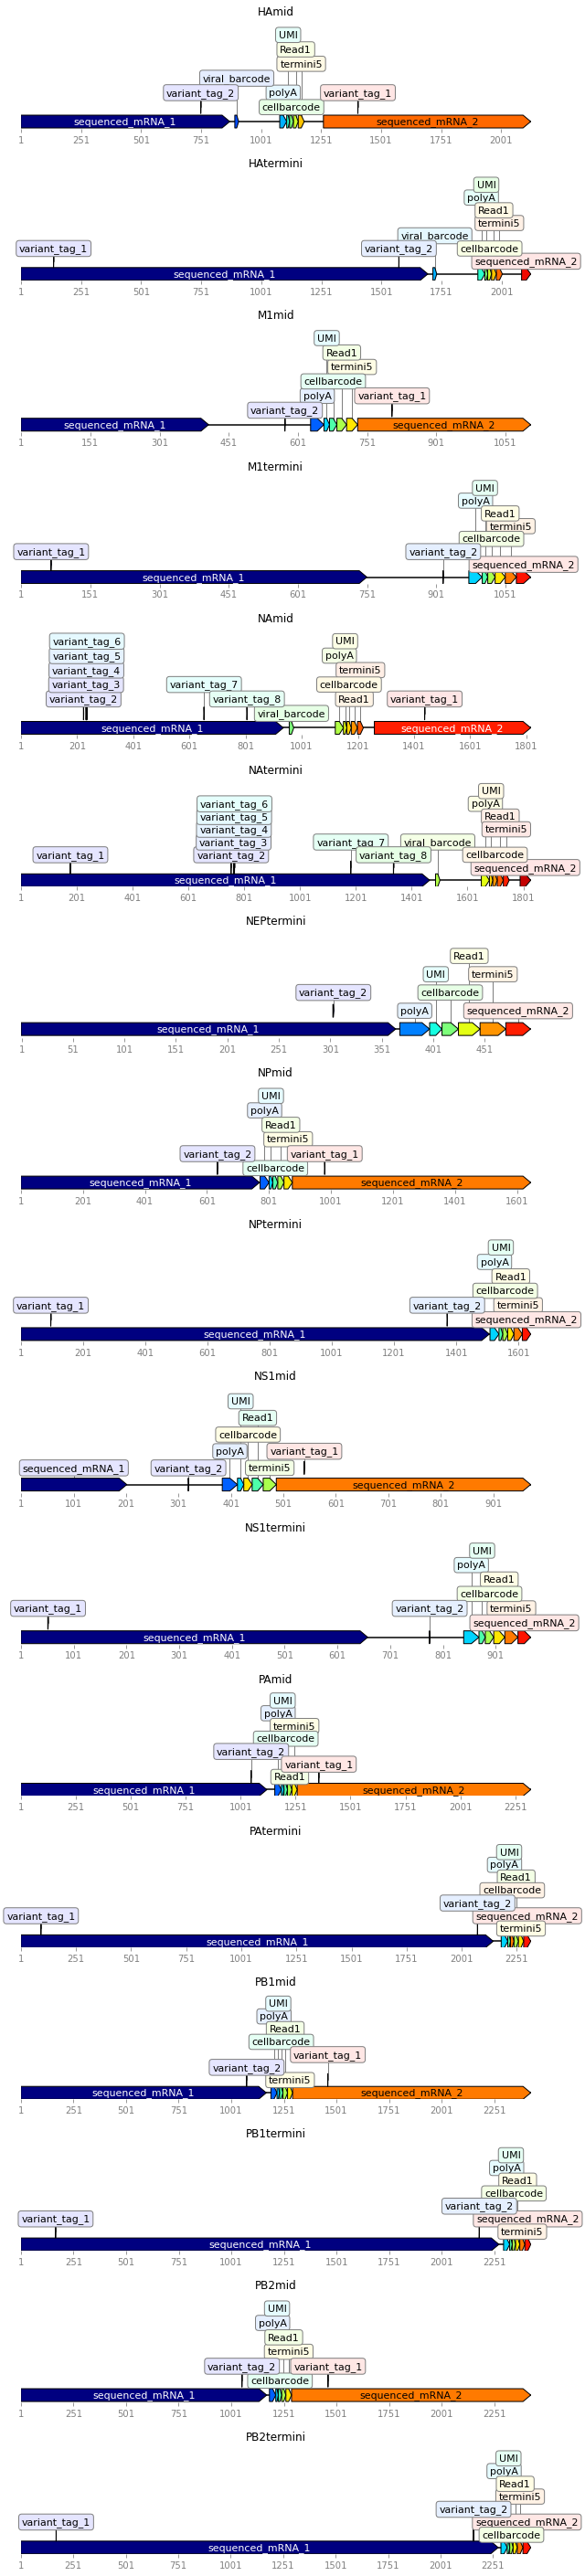

In [8]:
plot = targets.plot(ax_width=10)

In [9]:
print(f"Saving figure to {plot_amplicons}")
plot.savefig(plot_amplicons, format="svg")

Saving figure to ../results/pacbio/hashing_highMOI_amplicons.svg


Create packbio run dataframe

In [10]:
pacbio_runs = pd.DataFrame({'name': runs, 'fastq': ccs_fastq, 'report': ccs_report})
display(HTML(pacbio_runs.to_html(index=False)))

name,fastq,report
hashing_highMOI_2020-10-20_all_segments_run1_ccs,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs.fastq.gz,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt


## Align reads

The following section aligns all ccs to amplicons.

Create an alignparse.minimap2.Mapper to run minimap2 with minimap [options](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.OPTIONS_VIRUS_W_DEL) that allow for large deletions in viral sequences. 

In [12]:
alignparse.minimap2.OPTIONS_VIRUS = ('-xsplice:hq', '-un', '-C0', '--splice-flank=no', '-M=1','--end-seed-pen=2', '--end-bonus=2', '--secondary=no', '--cs')

In [13]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_VIRUS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-xsplice:hq -un -C0 --splice-flank=no -M=1 --end-seed-pen=2 --end-bonus=2 --secondary=no --cs


In [14]:
os.makedirs(alignment_stats, exist_ok=True)

align_and_parse_outdir = os.path.join(alignment_stats, "alignments")

In [15]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=align_and_parse_outdir,
        name_col='name',
        queryfile_col='fastq',
        overwrite=True,  # overwrite any existing output
        ncpus=-1,  # use all available CPUs
        )

Here are read alignment statistics:

In [16]:
readstats

,name,category,count
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered HAmid,3649
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned HAmid,11358
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered HAtermini,2179
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned HAtermini,4047
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered M1mid,405
5,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned M1mid,0
6,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered M1termini,3863
7,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned M1termini,10643
8,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered NAmid,5569
9,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned NAmid,14006


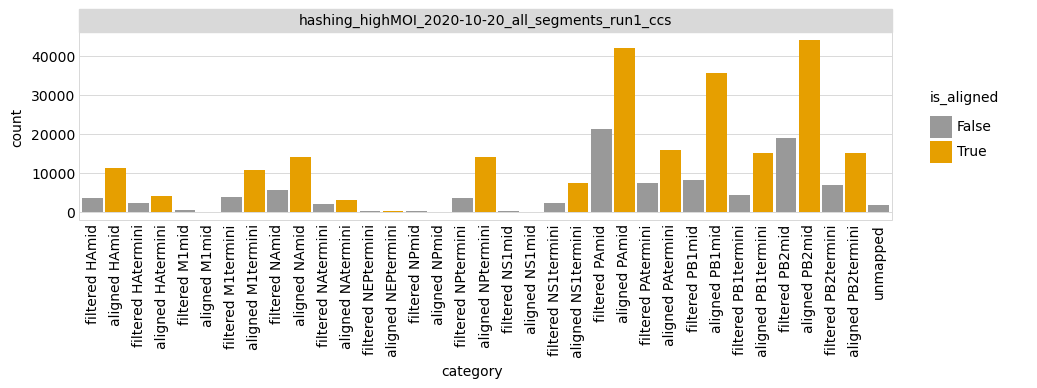

In [17]:
p = (
    p9.ggplot(readstats.assign(
               category=lambda x: pd.Categorical(x['category'],
                                                 x['category'].unique(),
                                                 ordered=True),
               is_aligned=lambda x: x['category'].str.contains('aligned'),
               ),
           p9.aes('category', 'count', fill='is_aligned')) +
    p9.geom_bar(stat='identity') +
    p9.facet_wrap('~ name', nrow=1) +
    p9.theme(axis_text_x=p9.element_text(angle=90),
          figure_size=(0.3 * len(readstats), 2.5),
          panel_grid_major_x=p9.element_blank()  # no vertical grid lines
          ) +
    p9.scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

In [18]:
for target in targets.target_names[:1]:
    print(f"First few lines of `filtered` for {target}:")
    display(filtered[target].head())

First few lines of `filtered` for HAmid:


,name,query_name,filter_reason
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194761/ccs,query_clip5
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194985/ccs,query_clip5
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4260097/ccs,termini5 clip3
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4260187/ccs,sequenced_mRNA_2 clip3
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4325657/ccs,query_clip5


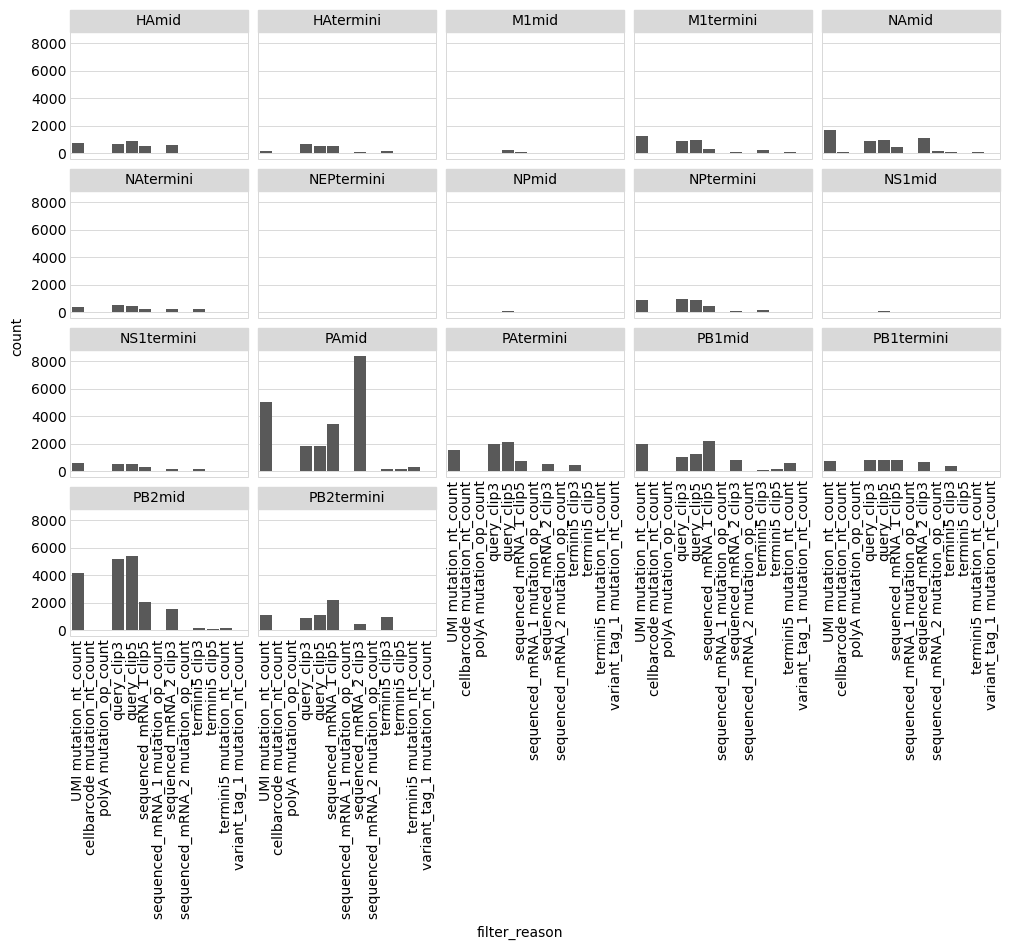

In [19]:

p = (
    p9.ggplot(pd.concat([df.assign(gene=gene) for gene, df
                      in filtered.items()])
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   x['gene'].unique(),
                                                   ordered=True)),
           p9.aes('filter_reason')) +
    p9.geom_bar() +
    p9.facet_wrap('~ gene', ncol=5) +
    p9.theme(axis_text_x=p9.element_text(angle=90),
          figure_size=(12, 8),
          panel_grid_major_x=p9.element_blank(),  # no vertical grid lines
          )
    )

_ = p.draw()